In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sma
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/content/drive/MyDrive/abalone.csv")

In [3]:
df.rename(columns={"Sex":"sex", "Length":"length", "Diameter":"diameter",
                   "Height":"height", "Whole weight":"whole_weight",
                   "Shucked weight":"shucked_weight", "Viscera weight":"viscera_weight",
                   "Shell weight":"shell_weight", "Rings":"rings"}, inplace = True)

In [4]:
df[df['height'] == 0]  #need to drop these rows.
df.drop(index=[1257,3996], inplace = True)
df.shape

(4175, 9)

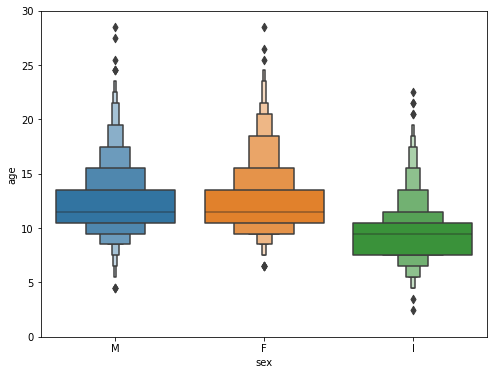

In [5]:
df['age'] = df['rings']+1.5 #AS per the problem statement
df.drop('rings', axis = 1, inplace = True)
df.head()
#categorical features
temp = pd.concat([df['age'], df['sex']], axis=1)

f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxenplot(x='sex', y="age", data=df)
fig.axis(ymin=0, ymax=30);

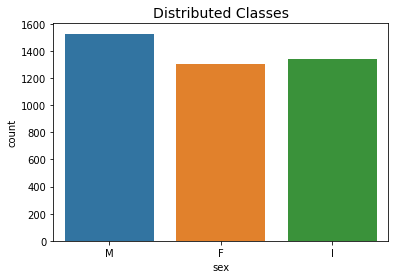

In [6]:
sns.countplot('sex', data=df)
plt.title('Distributed Classes', fontsize=14)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9818f073d0>,
      dtype=object)

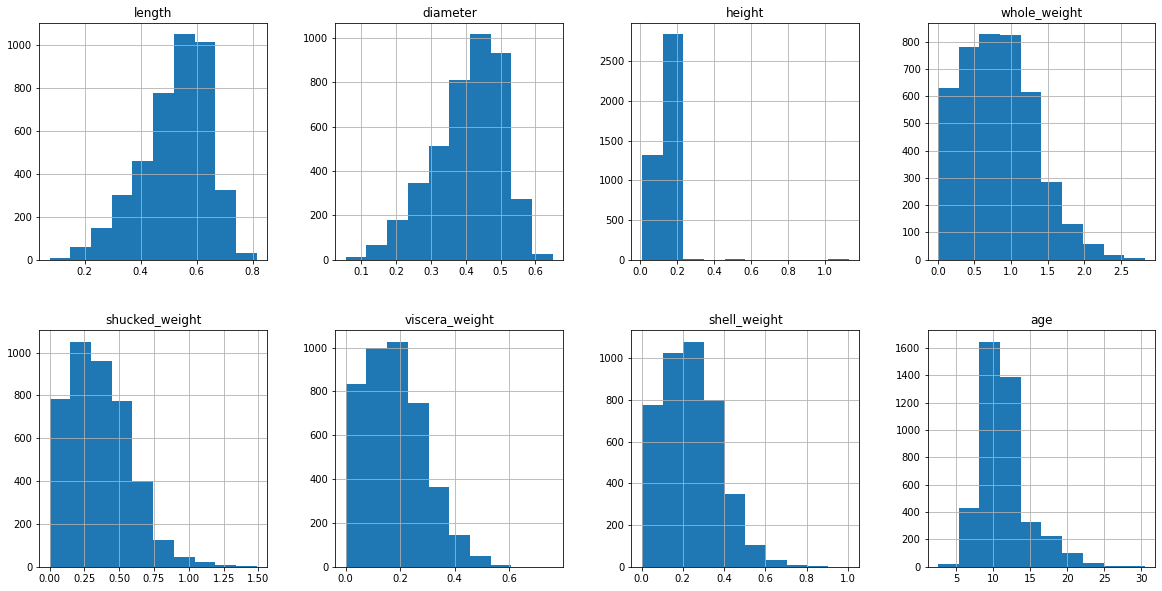

In [7]:
df.hist(figsize = (20,10), layout = (2,4))

In [8]:
df.skew().sort_values(ascending = False)

height            3.166364
age               1.113754
shucked_weight    0.718735
shell_weight      0.621081
viscera_weight    0.591455
whole_weight      0.530549
diameter         -0.610182
length           -0.640993
dtype: float64

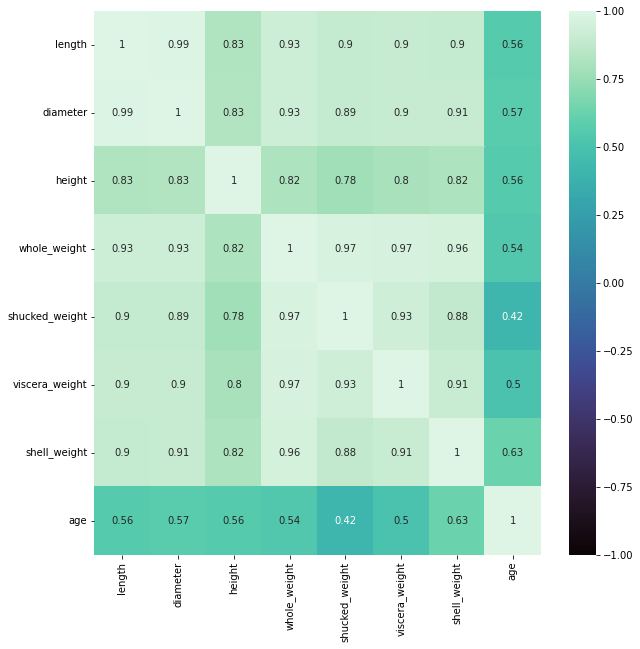

In [9]:
corr = df.corr()
plt.figure(figsize = (10,10))
ax = sns.heatmap(corr, vmin = -1, center = 0, annot = True, cmap = 'mako')


In [10]:
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
columns_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)] #highly correlated variables to be removed.

print("Columns to drop:\n", columns_to_drop)


Columns to drop:
 ['diameter', 'shucked_weight', 'viscera_weight', 'shell_weight']


In [11]:
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


In [12]:

df.shape

(4175, 9)

In [13]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4175 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4175 non-null   object 
 1   length          4175 non-null   float64
 2   diameter        4175 non-null   float64
 3   height          4175 non-null   float64
 4   whole_weight    4175 non-null   float64
 5   shucked_weight  4175 non-null   float64
 6   viscera_weight  4175 non-null   float64
 7   shell_weight    4175 non-null   float64
 8   age             4175 non-null   float64
dtypes: float64(8), object(1)
memory usage: 455.2+ KB


In [14]:

df[df.duplicated()]

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,age


In [15]:
for i in df:
    if df[i].dtype=='int64' or df[i].dtypes=='float64':
        q1=df[i].quantile(0.25)
        q3=df[i].quantile(0.75)
        iqr=q3-q1
        upper=q3+1.5*iqr
        lower=q1-1.5*iqr
        df[i]=np.where(df[i] >upper, upper, df[i])
        df[i]=np.where(df[i] <lower, lower, df[i])

In [16]:

import matplotlib.pyplot as mtp

In [17]:
def box_scatter(data, x, y):    
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
    sns.boxplot(data=data, x=x, ax=ax1)
    sns.scatterplot(data=data, x=x,y=y,ax=ax2)


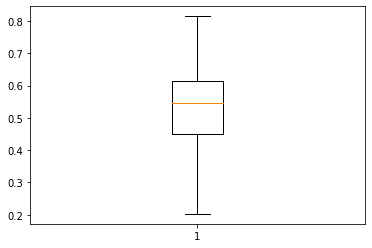

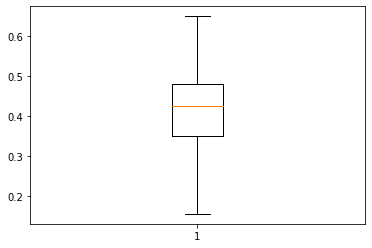

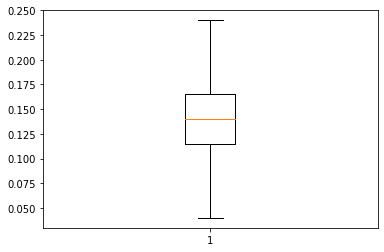

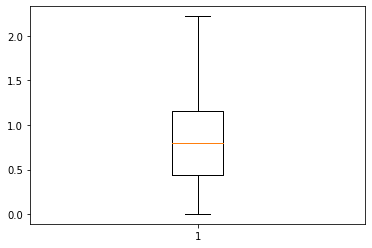

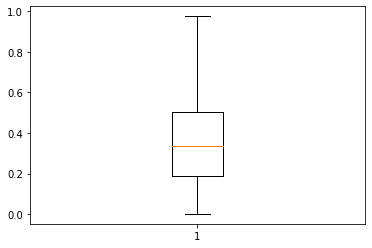

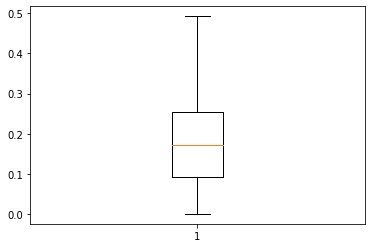

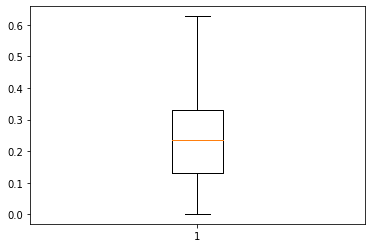

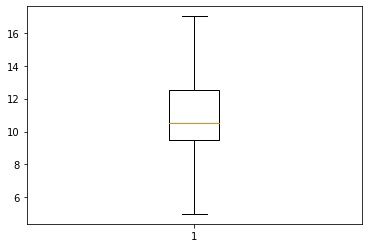

In [18]:
for i in df:
    if df[i].dtype=='int64' or df[i].dtypes=='float64':
        mtp.boxplot(df[i])
        mtp.show()

In [19]:
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


In [20]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
df['sex']=encoder.fit_transform(df['sex'])
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,age
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


In [21]:
x=df.iloc[:,:-1]
x.head()


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [24]:
y=df.iloc[:,-1]
y.head()

0    16.5
1     8.5
2    10.5
3    11.5
4     8.5
Name: age, dtype: float64

In [22]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x=scaler.fit_transform(x)

In [25]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.33)

In [26]:
x_train.shape

(2797, 8)

In [27]:

x_test.shape

(1378, 8)

In [28]:
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor()

In [29]:

reg.fit(x_train,y_train)

RandomForestRegressor()

In [30]:
y_pred=reg.predict(x_test)

In [31]:
from sklearn.metrics import mean_squared_error
import math
print(math.sqrt(mean_squared_error(y_test,y_pred)))

1.8306598073341425
